<h1>Decision tree and Random forest</h1>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Machine learning/data/final_spotify_tracks.csv')
data.set_index('title', inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [3]:
genres = data['top genre']

In [4]:
enc = LabelEncoder()
data['artist'] = enc.fit_transform(data['artist'])
data['top genre'] = enc.fit_transform(data['top genre'])
labels = ['track_popularity']
features = data.columns.drop(labels)
X = data[features]
Y = data[labels]

In [6]:
X = X.fillna(X.median())

Defining a method for Leave one out cross validation for regression.

In [10]:
def cross_validation_regression(X, Y, model): 
  predicted = []
  actual = []
  folds = LeaveOneOut()

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(list(Y_test.values))

  return predicted, actual

Defining a method that performs grid search using internal 5-fold cross validation and optimizing mean squared error.

In [18]:
def hyper_parameter_search(X, Y, params, model):
  gscv = GridSearchCV(model, params, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)
  model_best = gscv.fit(X = X, y=Y)
  return model_best.best_params_, model_best.best_score_

Defining a method for drawing feature importance graphs for random forest using shapley values from game theory

In [49]:
def shap_graphs(model, X, Y):
  model.fit(X, Y)
  expl = shap.Explainer(model, X)
  shap_values = expl(X)
  shap.plots.bar(shap_values, max_display=20)
  shap.plots.beeswarm(shap_values, max_display=20)

<h3>Decision tree for regression</h3>

In [19]:
PARAMS_TREE = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [3, 5, 8],
    'min_samples_leaf' : [3, 4, 5]
}

The above parameters are used for grid search.

In [20]:
params_tree, score_tree = hyper_parameter_search(X, Y, PARAMS_TREE, DecisionTreeRegressor())

In [21]:
print(f'params: {params_tree}, score: {score_tree}')

params: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3}, score: -252.72957740296798


The best chosen parameters are max_depth=5, min_samples_leaf =3 and min_samples_split = 3 with a negative mse of -252.73

In [22]:
reg_tree = DecisionTreeRegressor(
    max_depth = params_tree['max_depth'],
    min_samples_split = params_tree['min_samples_split'],
    min_samples_leaf = params_tree['min_samples_leaf']
)

In [23]:
preds_tree, actual_tree = cross_validation_regression(X, Y, reg_tree)

In [24]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(actual_tree, preds_tree)}')
print(f'MAE: {mean_absolute_error(actual_tree, preds_tree)}')
print(f'R2 Score: {r2_score(actual_tree, preds_tree)}')

----------------------
Scores: 
----------------------
MSE: 193.93713053912703
MAE: 10.022275060617355
R2 Score: 0.0686589789282398


The single decision tree has similar performance to the basic linear regression, but they are a bit worse. 

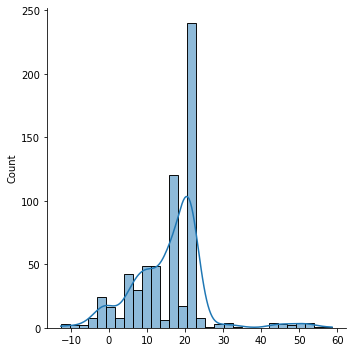

In [39]:
sns.displot(np.subtract(actual_tree,preds_tree)[0],bins=30, kde=True)
plt.show()

The error distribution is not normal and not centered in zero.

Very variable errors. This is expected since decision trees are high variance estimators.

In [27]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image  

dot_data = export_graphviz(reg_tree, out_file=None, feature_names=X.columns,
                           class_names = labels[0],
                           filled = True, rounded = True,
                           special_characters = True)
graph = graphviz.Source(dot_data)
graph.render('spotify_tracks')

'spotify_tracks.pdf'

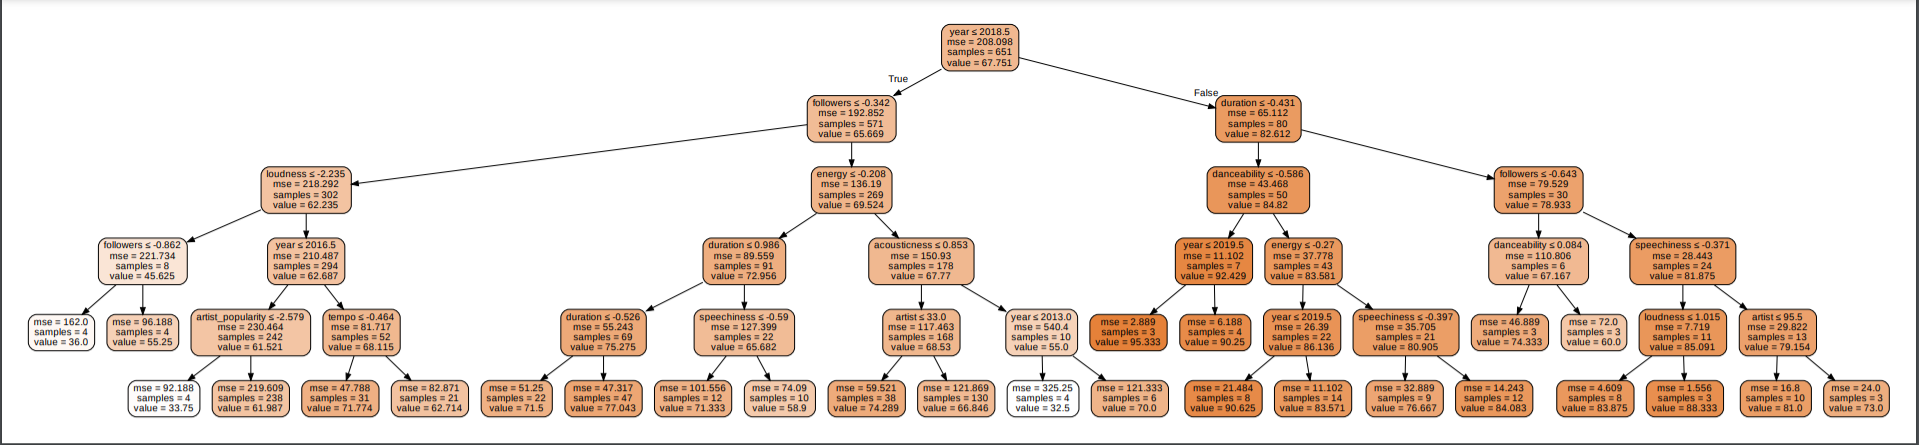

This is the unpruned decision tree learnt from the data.

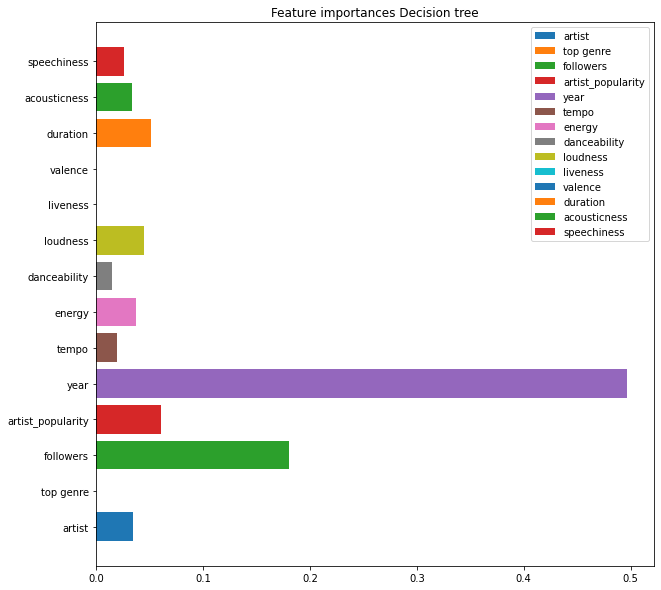

In [31]:
x_plot = np.arange(1, len(reg_tree.feature_importances_) + 1)
plt.figure(figsize=(10,10))
for i, feat in enumerate(reg_tree.feature_importances_):
  plt.barh(i+1, feat, label=X.columns[i])

plt.yticks(x_plot, X.columns)
plt.title('Feature importances Decision tree')
plt.legend()
plt.show()

Year and followers are the most important features for the decision tree. This is consistent with the xgboost regressor.

<h3>Random Forest</h3>

In [41]:
PARAMS_RF = {
    'max_depth': [3, 5, 7],
    'max_features': [1.0, 0.8],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [50, 100, 200, 300]
}

Defining the parameters for gridsearch for random forest.

In [42]:
params_rf, score_rf = hyper_parameter_search(X, Y, PARAMS_RF, RandomForestRegressor(n_jobs=-1 ))

In [43]:
print(f'params: {params_rf}, score: {score_rf}')

params: {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 4, 'n_estimators': 50}, score: -193.60906843157076


The best chosen parameters are max_dept=3, max_features=0.8, min_samples_leaf=4 and n_estimators=50

In [44]:
rf = RandomForestRegressor(
    max_depth = params_rf['max_depth'],
    max_features = params_rf['max_features'],
    min_samples_leaf = params_rf['min_samples_leaf'],
    n_estimators = params_rf['n_estimators']
)

In [45]:
preds_rf, actual_rf = cross_validation_regression(X, Y, rf)

In [46]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(actual_rf, preds_rf)}')
print(f'MAE: {mean_absolute_error(actual_rf, preds_rf)}')
print(f'R2 Score: {r2_score(actual_rf, preds_rf)}')

----------------------
Scores: 
----------------------
MSE: 163.47609558058923
MAE: 9.388559037118602
R2 Score: 0.21494149492877213


The results of the random forest are significantly better than those of the single decision tree.

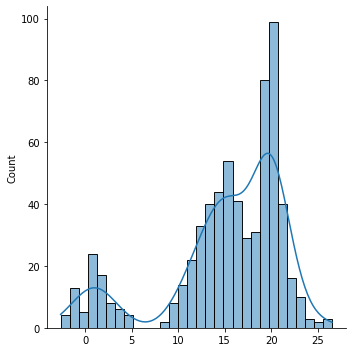

In [47]:
sns.displot(np.subtract(actual_rf,preds_rf)[0],bins=30, kde=True)
plt.show()

The error distribution is bi-modal, but decision trees and random forest do not expect a normally distributed error.

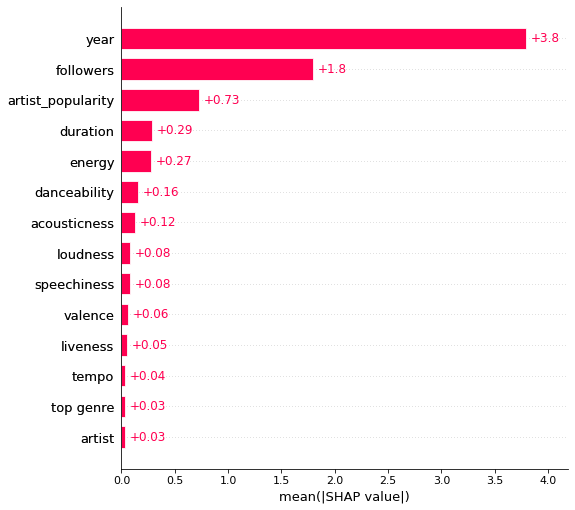

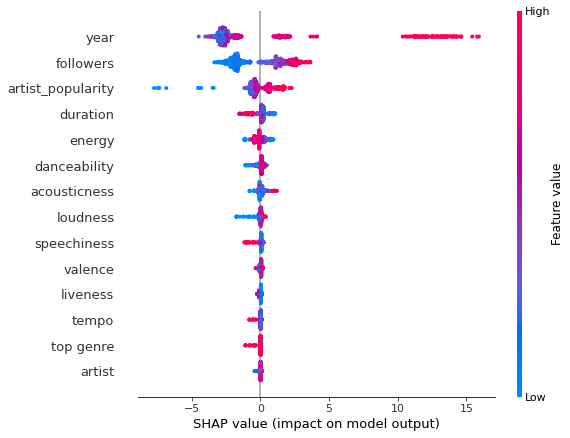

In [50]:
shap_graphs(rf, X, Y)

The shap beeswarm plot shows that songs in recent years are generally more popular than tracks made in the past, the more followers an artists has the more popular their songs are, longer songs contribute to predicting a lower popularity and shorter songs have a contribution towards predicting higher popularity. These results are consistent with xgboost.